In [2]:
"""
Grid preparation for future aspen project:

Future:
    - Future aspen suitability
    - Future fire probability

Contemporary:
    - ca. 2019 Aspen canopy cover
    - combustible mass of the built environment
    - burn probability and conditional flame length probability
    - ca. 2016 USFS TreeMap summaries (potential aspen understory, etc)

Author: maxwell.cook@colorado.edu
"""

import os, sys, time
import pandas as pd
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from tqdm.notebook import tqdm
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from sklearn.preprocessing import MinMaxScaler

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/')

# Custom functions
sys.path.append(os.path.join(maindir,'aspen-fire/Aim2/code/Python'))
from __functions import *

proj = 'EPSG:5070' # albers

print("Ready to go !")

Ready to go !


## Future Fire

In [4]:
fp = os.path.join(projdir,'Aim3/data/spatial/mod/future_fire_grid_trend.gpkg')
future_fire = gpd.read_file(fp)
future_fire.head()

,grid_id,trend_area,trend_count,p_area,p_count,NA_L3NAME,US_L4NAME,US_L4CODE,geometry
0,159230.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-861518.632 2246765.246, -858285.087..."
1,159231.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-858285.087 2246403.307, -855051.389..."
2,159232.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-855051.389 2246042.730, -851817.539..."
3,159233.0,301.282740,0.026862,1.926234e-07,1.677490e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-851817.539 2245683.513, -848583.540..."
4,159234.0,411.936265,0.034504,3.852110e-07,3.354837e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-848583.540 2245325.656, -845349.389..."


## Aspen habitat suitability metrics

In [5]:
# load the future aspen suitability
fp = os.path.join(projdir,'Aim3/data/spatial/raw/aspen_suitability/Predictions/predicted_SSP245_2041-2070_ensemble.tif')
aspen = rxr.open_rasterio(fp, cache=False).squeeze()
print(f"\n{aspen}\n")


<xarray.DataArray (y: 9317, x: 5715)> Size: 213MB
[53246655 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 46kB 9.022e+04 9.03e+04 ... 6.044e+05 6.045e+05
  * y            (y) float64 75kB 4.74e+06 4.74e+06 ... 3.902e+06 3.902e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  0.72700226306915
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  0.012364179827273
    STATISTICS_STDDEV:   -9999
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           suitability



In [6]:
aspen.rio.crs

CRS.from_epsg(32613)

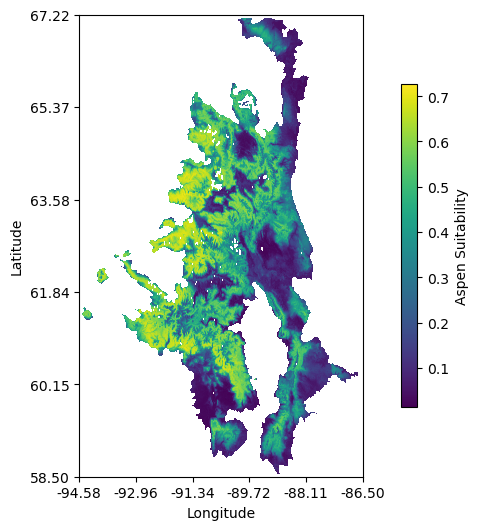

In [7]:
plot_raster(aspen, legend_lab = "Aspen Suitability")

In [8]:
# calculate band statistics
# mean, standard deviation, percentiles

# reproject the aspen grid
aspen = aspen.rio.reproject(proj)

# calculate zonal statistics
future_aspen = compute_band_stats(
    geoms=future_fire, 
    image_da=aspen, 
    id_col='grid_id', 
    stats=['mean','median','std','percentile_90'],
    attr='f_aspen',
    ztype='continuous'
)

future_aspen.head()

,grid_id,f_aspen_mean,f_aspen_median,f_aspen_std,f_aspen_percentile_90
0,159230.0,0.141750,0.141508,0.010395,0.155929
1,159231.0,0.128937,0.127623,0.026047,0.162471
2,159232.0,0.151842,0.153979,0.022279,0.176028
3,159233.0,0.158245,0.152208,0.038911,0.207930
4,159234.0,0.201934,0.193113,0.054121,0.283402


In [10]:
# rename the columns
future_aspen = future_aspen.rename(
    columns={
        'f_aspen_percentile_90': 'f_aspen_p90',
        'f_aspen_mean': 'f_aspen_mn',
        'f_aspen_median': 'f_aspen_med'
    }
)

# join to the fire dataframe
fire_fa = pd.merge(future_fire, future_aspen, on="grid_id", how="left")
fire_fa.head()

,grid_id,trend_area,trend_count,p_area,p_count,NA_L3NAME,US_L4NAME,US_L4CODE,geometry,f_aspen_mn,f_aspen_med,f_aspen_std,f_aspen_p90
0,159230.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-861518.632 2246765.246, -858285.087...",0.141750,0.141508,0.010395,0.155929
1,159231.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-858285.087 2246403.307, -855051.389...",0.128937,0.127623,0.026047,0.162471
2,159232.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-855051.389 2246042.730, -851817.539...",0.151842,0.153979,0.022279,0.176028
3,159233.0,301.282740,0.026862,1.926234e-07,1.677490e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-851817.539 2245683.513, -848583.540...",0.158245,0.152208,0.038911,0.207930
4,159234.0,411.936265,0.034504,3.852110e-07,3.354837e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-848583.540 2245325.656, -845349.389...",0.201934,0.193113,0.054121,0.283402


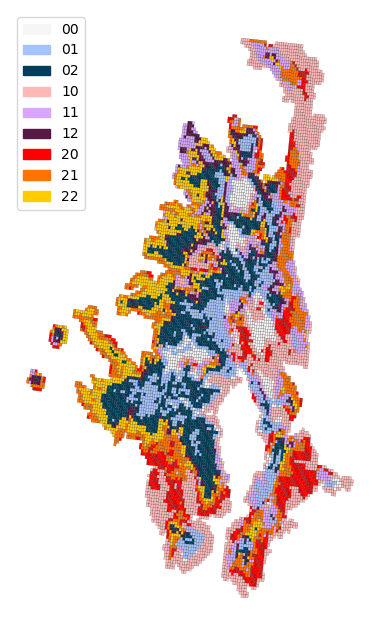

In [14]:
# Create a bivariate map of future fire/future aspen
scaler = MinMaxScaler()
fire_fa[["trend_count_sc", "trend_area_sc", "f_aspen_mn_sc"]] = scaler.fit_transform(fire_fa[["trend_count", "trend_area", "f_aspen_mn"]])

# Define class breaks (e.g., tertiles or quartiles)
fire_fa["fire_class"] = np.digitize(
    fire_fa["trend_count_sc"], 
    np.quantile(fire_fa["trend_count_sc"], [0.33, 0.67]))
fire_fa["aspen_class"] = np.digitize(
    fire_fa["f_aspen_mn_sc"], 
    np.quantile(fire_fa["f_aspen_mn_sc"], [0.33, 0.67]))

# Combine classifications to create bivariate classes
fire_fa["bivar"] = fire_fa["fire_class"].astype(str) + fire_fa["aspen_class"].astype(str)

# Define a custom bivariate colormap
bivar_colors = {
    "00": "#f6f6f6",  # Low fire, low aspen
    "01": "#a5c3ff",  # Low fire, medium aspen
    "02": "#003f5c",  # Low fire, high aspen
    "10": "#ffb8b8",  # Medium fire, low aspen
    "11": "#d9a6ff",  # Medium fire, medium aspen
    "12": "#581845",  # Medium fire, high aspen
    "20": "#ff0000",  # High fire, low aspen
    "21": "#ff7300",  # High fire, medium aspen
    "22": "#ffcc00",  # High fire, high aspen
}

# Assign colors based on the classification
fire_fa["color"] = fire_fa["bivar"].map(bivar_colors)

# Plot the bivariate map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fire_fa.plot(ax=ax, color=fire_fa["color"], edgecolor="black", linewidth=0.1)

legend_patches = [Patch(color=color, label=label) for label, color in bivar_colors.items()]
ax.legend(handles=legend_patches, title="", loc="upper left")
ax.axis("off")

plt.show()

In [15]:
# save this file out
out_fp = os.path.join(projdir, 'Aim3/data/spatial/mod/future_fire_grid_trend_aspen.gpkg')
fire_fa.to_file(out_fp)
print(f"Saved to: \n{out_fp}")

Saved to: 
/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim3/data/spatial/mod/future_fire_grid_trend_aspen.gpkg


## Sentinel-based aspen cover (ca. 2019)

In [34]:
# load the 10-m aspen map (classification)
aspen10_fp = os.path.join(projdir,'Aim1/data/spatial/mod/results/classification/s2aspen_distribution_10m_y2019_CookEtAl.tif')
aspen10 = rxr.open_rasterio(aspen10_fp, cache=False, chunks='auto', mask=True).squeeze()
print(f"\n{aspen10}\n")
print(aspen10.rio.crs)


<xarray.DataArray (y: 95433, x: 64151)> Size: 6GB
dask.array<getitem, shape=(95433, 64151), dtype=uint8, chunksize=(2092, 64151), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 513kB -1.217e+06 -1.217e+06 ... -5.76e+05 -5.76e+05
  * y            (y) float64 763kB 2.309e+06 2.309e+06 ... 1.355e+06 1.355e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        1
    STATISTICS_MEAN:           0.015830995519141
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         0.1248213727693
    STATISTICS_VALID_PERCENT:  100
    _FillValue:                255
    scale_factor:              1.0
    add_offset:                0.0

EPSG:5070


In [35]:
# check for duplicates, remove them
n = future_fire.duplicated(subset=['grid_id']).sum()
if n > 0:
    print(f"\nThere are [{n}] duplicate rows.\n")
else:
    print("\nNo duplicates at this stage.\n")


No duplicates at this stage.



In [37]:
t0 = time.time()

# calculate zonal statistics
aspen10_grids = compute_band_stats(
    geoms=future_fire, 
    image_da=aspen10, 
    id_col='grid_id', 
    attr='aspen10',
    ztype='categorical'
)
# only keep the count of aspen pixels
aspen10_grids = aspen10_grids[aspen10_grids['aspen10'] == 1]
# check the results
print(aspen10_grids.head())

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")

    grid_id  aspen10  count  total_pixels  pct_cover
1  159230.0        1      8        146335   0.005467
3  159231.0        1     23        146342   0.015717
5  159232.0        1    764        146346   0.522050
7  159233.0        1    100        146336   0.068336
9  159234.0        1    369        146336   0.252159

Total elapsed time: 0.51 minutes.


~~~~~~~~~~



In [40]:
aspen10_grids['pct_cover'].describe()

count    9212.000000
mean        6.760243
std        11.574808
min         0.000617
25%         0.204016
50%         1.432681
75%         7.450748
max        80.162397
Name: pct_cover, dtype: float64

In [44]:
# seperate aspen grids for patch analysis
aspen_grids = aspen10_grids[aspen10_grids['pct_cover'] > 1] # grids where aspen percent cover is greater than 1%
print(f"\n[{len(aspen10_grids)}/{len(future_fire)}] grids with any aspen cover.")
print(f"\n\t[{len(aspen_grids)}/{len(future_fire)}] grids with >1% aspen cover.\n")


[9212/10319] grids with any aspen cover.

	[5073/10319] grids with >1% aspen cover.



In [46]:
# merge back to the spatial data
ff_aspen_grids = future_fire[future_fire['grid_id'].isin(aspen_grids['grid_id'].unique())]
print(len(ff_aspen_grids))

5073


In [49]:
t0 = time.time()

# patch analysis - largest patch size, mean patch size, etc
import pylandstats as pls
from joblib import Parallel, delayed

# define metrics to calculate
cls_metrics = [
    'number_of_patches',  'patch_density', 'largest_patch_index'
]

def process_grid(grid):
    try:
        bounds = grid.geometry.bounds
        bbox = box(*bounds)

        # extract the raster for the gridcell:
        arr = aspen10.rio.clip([bbox])
        # generate the landscape
        ls = pls.Landscape(arr.values, res=(10,10))
        # calculate the patch metrics
        patches = ls.compute_class_metrics_df(metrics=cls_metrics)
        patches["grid_id"] = grid.grid_id
        del arr, ls
        
        return patches
        
    except Exception as e:
        print(f"Error processing grid {row.grid_id}: {e}")

metrics_ = [] # to store the patch metrics

# Parallel processing using joblib
num_cores = -1  # Use all available cores
N = len(ff_aspen_grids)
results = Parallel(n_jobs=num_cores)(
    delayed(process_grid)(grid) for _, grid in tqdm(ff_aspen_grids.iterrows(), total=N)
)
        
# merge the patch metrics
metrics_df = pd.concat(filter(None, results), ignore_index=True)
metrics_df.to_csv(os.path.join(projdir,"data/tabular/aspen_patch_metrics.csv"), index=False)

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")

  0%|          | 0/5073 [00:00<?, ?it/s]

Module /opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/pylandstats/landscape.py has not been compiled for Transonic-Pythran
Module /opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/pylandstats/landscape.py has not been compiled for Transonic-Pythran
Module /opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/pylandstats/landscape.py has not been compiled for Transonic-Pythran
Module /opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/pylandstats/landscape.py has not been compiled for Transonic-Pythran
Module /opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/pylandstats/landscape.py has not been compiled for Transonic-Pythran
Module /opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/pylandstats/landscape.py has not been compiled for Transonic-Pythran
Module /opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/pylandstats/landscape.py has not been compiled for Transonic-Pythran
Module /opt/miniconda3/envs/aspen-fire/li

KeyboardInterrupt: 

## WUI/Built Environment Summaries

In [ ]:
# load the contemporary COMBUST grid (combustible mass of the built environment)

## Contemporary Fire Activity and Fire Risk 

In [ ]:
# load the burn probability and conditional flame length probability

In [ ]:
# load the fpa-fod ignitions data and get the total count

In [ ]:
# load burned area and calculate the cumulative area burned

## USFS TreeMap Summaries
### FORTYPCD

In [ ]:
# Load the TreeMap (ca. 2016)
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "Aim2/data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the tm_id band
fortyp_da = treemap_da.sel(band=2) # the fortypcd band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = fortyp_da.shape, fortyp_da.spatial_ref.GeoTransform, fortyp_da.rio.crs, fortyp_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {fortyp_da[0].dtype}")

del treemap_da # clean up
gc.collect()

In [ ]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(fortyp_da), 1, 0)
# calculate the grid-level forest percent
forest_pct = compute_band_stats(fire, forest_mask, 'grid_id', attr='forest')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
print(forest_pct.head())
# gather the forest percent
forest_pct = forest_pct[forest_pct['forest'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_id','forest_pixels','forest_pct']]
# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(fire)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")
# tidy up
del forest_mask
gc.collect() # clean up

In [ ]:
# calculate forest type percent from the FORTYPCD
t0 = time.time()

# see __functions.py
fire_fa_fortyp = compute_band_stats(fire_fa, fortyp_da, 'grid_id', attr='fortypcd')
# tidy columns in the summary table
fire_fa_fortyp['count'] = fire_fa_fortyp['count'].astype(int)
fire_fa_fortyp['total_pixels'] = fire_fa_fortyp['total_pixels'].astype(int)
fire_fa_fortyp.rename(columns = {'count': 'fortyp_pixels'}, inplace=True)

# load the species lookup table
fp = os.path.join(projdir,'Aim2/data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df.rename(columns={
    'FORTYPCD': 'fortypcd',
    'SpeciesName': 'fortypnm'
}, inplace=True)

# join the forest name
fire_fa_fortyp = fire_fa_fortyp.merge(species_df, on='fortypcd', how='left')
print(f"\n{fire_fa_fortyp.head(3)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del fortyp_da, species_df # clean up 
gc.collect()

In [ ]:
fire_fa_fortyp['fortypnm'].unique()

In [ ]:
# subset to southern rockies forest types
fortyp_srm = [
    'Rocky Mountain juniper', 'Juniper woodland', 'Pinyon / juniper woodland', 'Douglas-fir', 'Ponderosa pine',
    'White fir', 'Engelmann spruce', 'Cottonwood', 'Aspen', 'Deciduous oak woodland', 'Lodgepole pine', 
    'Willow', 'Cercocarpus (mountain brush) woodland', 'Engelmann spruce / subalpine fir', 'Subalpine fir', 
    'Foxtail pine / bristlecone pine', 'Limber pine', 'Cottonwood / willow', 'Blue spruce', 'Evergreen oak woodland', 
    'Mixed upland hardwoods'
]

# subset the dataframe
fire_fa_fortyp = fire_fa_fortyp[fire_fa_fortyp['fortypnm'].isin(fortyp_srm)]

# Aggregate into forest groups
spp_grouping = {
    'pinyon|juniper': 'Piñon-juniper',
    'spruce|subalpine': 'Spruce-fir',
    'ponderosa pine': 'Ponderosa pine', 
    'lodgepole pine': 'Lodgepole pine', 
    
    'aspen': 'Quaking aspen',
    'douglas-fir': 'Douglas-fir',
    'white fir': 'White fir',
    'deciduous oak woodland|cercocarpus': 'Oak woodland',
    'cottonwood|willow|': 'Riparian woodland'
}

# create the remap table
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = fire_fa_fortyp[fire_fa_fortyp['fortypnm'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update(
        {name: spp_group for name in spp['fortypnm'].unique()}
    )
    del spp
    
# Apply the remap to create a new grouped species column
fire_fa_fortyp['fortypnm_gp'] = fire_fa_fortyp['fortypnm'].map(spp_remap).fillna(fire_fa_fortyp['fortypnm'])
# Verify the updated species groups
print(fire_fa_fortyp[['fortypnm', 'fortypnm_gp']].drop_duplicates().head(3))
print(f"\n{fire_fa_fortyp.columns}")

In [ ]:
# Aggregate with the new species groupings
# Reacalculate the percent cover for each species group
fire_fa_fortypgp = (
    fire_fa_fortyp.groupby(['grid_id','fortypnm_gp'], as_index=False)
    .agg(
        fortyp_pixels=('fortyp_pixels','sum'),
        total_pixels=('total_pixels','max'),
        fortyp_pct=('pct_cover','sum'),
    )
)

# Merge in the forest percent
fire_fa_fortypgp = fire_fa_fortypgp.merge(forest_pct, on='grid_id', how='inner')

# Check on nulls introduced
print(f"\nNaNs in FORTYP group name: {fire_fa_fortypgp['fortypnm_gp'].isna().sum()}\n")
print(f"\n{fire_fa_fortypgp.head(10)}\n")
print(f"Forest percent:\n{fire_fa_fortypgp['forest_pct'].describe()}\n")
print("\n~~~~~~~~~~~~~~~~~~\n")

gc.collect()

In [ ]:
# Create a histogram of the forest species (prevalence)
fortyp = fire_fa_fortypgp.copy() # make a copy to work with
fortyp = fortyp[fortyp['fortyp_pixels'] > 0] # make sure there are some pixels

# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('fortypnm_gp')['fortyp_pixels'].sum().reset_index()
spp_pr['fraction'] = spp_pr['fortyp_pixels'] / spp_pr['fortyp_pixels'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.99]
print(f"\n\nSpecies making up 99% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='fortypnm_gp', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# clean up
del fortyp, spp_pr
gc.collect()

In [ ]:
# Get the species co-occurrence percentages
spps = fire_fa_fortypgp['fortypnm_gp'].unique()
coo = get_spp_coo(fire_fa_fortypgp, spps, grid_col='grid_id') # see '__functions.py')
print(f"\n{coo.head(30)}\n")

In [ ]:
# merge to the fire data again
fire_fa_tm = pd.merge(fire_fa, fire_fa_fortypgp, on='grid_id', how='left')
fire_fa_tm.columns

In [ ]:
print(len(fire_fa_tm))
print(len(fire_fa_tm['grid_id'].unique()))

In [ ]:
fire_fa_tm['fortypnm_gp'].unique()

In [ ]:
# check how many grids have aspen/lodgepole FORTYPCD
lodgepole_grids = fire_fa_tm[fire_fa_tm['fortypnm_gp'] == 'Lodgepole']['grid_id'].unique()
aspen_grids = fire_fa_tm[fire_fa_tm['fortypnm_gp'] == 'Quaking aspen']['grid_id'].unique()
# find common grids
common_grids = set(lodgepole_grids) & set(aspen_grids)
df_cooccur = fire_fa_tm[fire_fa_tm['grid_id'].isin(common_grids)]
print(f"\n[{len(df_cooccur['grid_id'].unique())}] future fire grids with any aspen & lodgepole.")

### Tree Table

In [ ]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the "tm_id" band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = tmid_da.shape, tmid_da.spatial_ref.GeoTransform, tmid_da.rio.crs, tmid_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {tmid_da[0].dtype}")

del treemap_da
gc.collect()

In [ ]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_trees = compute_band_stats(grid, tmid_da, 'grid_idx', attr='tm_id')

# tidy columns in the summary table
grid_trees['count'] = grid_trees['count'].astype(int)
grid_trees['total_pixels'] = grid_trees['total_pixels'].astype(int)
grid_trees.rename(columns={
    'count': 'tmid_count',
    'pct_cover': 'tmid_pct'
}, inplace=True)

# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# join the Tree Table to the grid data
grid_trees = grid_trees.merge(tree_tbl, on='tm_id', how='left')
print(f"\n{grid_trees.head(12)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del tmid_da, tree_tbl # clean up 
gc.collect()

In [ ]:
# Calculate the Tree Table statistics across tm_id/grid_index combinations
#### Abundance (trees/acre, scaled to per-pixel)
#### Dominance (live basal area, scaled to per-pixel)
#### Tree height (average/species)
#### Tree diameter (average/species)
#### Quadratic mean diameter (QMD)

# force species name to lower case
grid_trees.rename(columns={'COMMON_NAME': 'species'}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
# tidy the live/dead column
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)
# add a tree/pixel based on scaling factor
grid_trees['tpp_unadj'] = grid_trees['TPA_UNADJ'] * 0.222395
# calculate live basal area (balive) scaled by TPA
grid_trees['BA'] = np.pi * (grid_trees['DIA'] / 2) ** 2  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['tpp_unadj']  # adjust based on tree abundance

# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead seperately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_idx', 'tm_id', 'species'], as_index=False)
    .agg(
        # grid-level attributes
        tmid_pixels=('tmid_count','max'), # retains the tm_id pixel count
        tmid_pct=('tmid_pct','max'), # retain the percent of forested area
        # calculate species-level attributes
        tpp_live=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_live=('BA_TPAsc', 'sum'),    # total BALIVE
        tree_ht_live=('HT','mean'), # average tree height
        tree_dia_live=('DIA','mean') # average diameter
    )
)

# dead trees
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_idx', 'tm_id', 'species'], as_index=False)
    .agg(
        tpp_dead=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_dead=('BA_TPAsc', 'sum'),    # Live basal area
        tree_ht_dead=('HT','mean'), # average tree height
        tree_dia_dead=('DIA','mean') # average diameter
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics, 
    on=['grid_idx', 'tm_id', 'species'], 
    how='outer'
).fillna(0)

# subset to the tree metric columns
tree_metrics = tree_metrics[[
    'grid_idx','tm_id','tmid_pixels','tmid_pct','species',
    'ba_live','ba_dead', # basal area
    'tpp_live','tpp_dead', # trees/pixel
    'tree_ht_live','tree_ht_dead', # tree height
    'tree_dia_live','tree_dia_dead' # tree diameter
]] 

# Add Quadratic Mean Diameter (QMD) for live and dead trees
# calculated as 'QMD = sqrt( (Basal Area per Acre / Trees per Acre) / 0.005454 )'
# https://www.fs.usda.gov/Internet/FSE_DOCUMENTS/stelprdb5413736.pdf
tree_metrics['qmd_live'] = np.where(
    tree_metrics['tpp_live'] > 0, 
    np.sqrt(tree_metrics['ba_live'] / (tree_metrics['tpp_live'] * 0.005454)), 0
)
tree_metrics['qmd_dead'] = np.where(
    tree_metrics['tpp_dead'] > 0, 
    np.sqrt(tree_metrics['ba_dead'] / (tree_metrics['tpp_dead'] * 0.005454)), 0
)

# Add combined (live + dead)
tree_metrics['tpp_ld'] = tree_metrics['tpp_live'] + tree_metrics['tpp_dead']
tree_metrics['ba_ld'] = tree_metrics['ba_live'] + tree_metrics['ba_dead']
tree_metrics['qmd_ld'] = tree_metrics['qmd_live'] + tree_metrics['qmd_dead']

# add in forest percent by grid
tree_metrics = tree_metrics.merge(
    grid[['grid_idx','forest_pixels','forest_pct']], 
    on='grid_idx', 
    how='left'
)

# filter out any rows with missing information
tree_metrics = tree_metrics[tree_metrics['tmid_pixels'] > 0]
print(f"\n{tree_metrics.head(12)}\n")
del live_metrics, dead_metrics, grid_trees
gc.collect()

In [ ]:
# gather the unique species present
unique_spp = tree_metrics['species'].unique()
unique_spp